# Working with "Largish" Data

Sample data is Takata airbag warranty claims saved as a .csv file.  It is a modest size of about 2.7GB.

We will compare 2 workflows:
- Using Dask
- Using PyArrow/fastparquet

### Dask Workflow

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client

client = Client()
client

Client Scheduler: tcp://127.0.0.1:51122,Cluster Workers: 4 Cores: 4 Memory: 8.41 GB


### Key thing is to set column types that are str/object to 'category' and float columns to float32

In [36]:
%%time
cols = ['WAR_CLAIM_DATE',
        'WAR_DEFECT_CODE',
        'VIN_MODEL_YR',
        'VIN_FACTORY',
        'VIN_MODEL_TYPE',
        'WAR_ORIG_DISTR_CDE',
        'WAR_RESP_DISTR_CDE',
        'WAR_EXCH_RATE_AMT',
        'CLAIM_LABOR_HRS_QTY',
        'WAR_LABOR_CHG_AMT_USD',
        'WAR_PARTS_CHG_AMT_USD',
        'WAR_HDLG_CHG_AMT_USD',
        'WAR_TOTAL_CHG_AMT_USD',
        'PHASE_TYPE',
        'PART_COST_25',
        'DRIVER_PASSENGER',
        'DIR_NUMBER',
        'NA_FCTRY_YES_NO',
        'PAB_TYPE',
        'DAB_TYPE',
        'STATE_CODE',
        'COUNTRY',
        'ZONE_REGION',
        'CLAIM_SUBLET_AMT_USD',
        'SUBLET_TYPE1_CODE',
        'SUBLET_TYPE2_CODE',
        'SUBLET_TYPE_DESC',
        'SUBLET_YES_NO',
        'WRWHA1_LABOR_CHG_AMT_USD',
        'FRGT_SUBL_TAX_AMT_USD'
       ]

data_type = {
        'WAR_CLAIM_DATE': np.int32,
        'WAR_DEFECT_CODE': 'category',
        'VIN_MODEL_YR': 'category',
        'VIN_FACTORY': 'category',
        'VIN_MODEL_TYPE': 'category',
        'WAR_ORIG_DISTR_CDE': 'category',
        'WAR_RESP_DISTR_CDE': 'category',
        'WAR_EXCH_RATE_AMT': np.float32,
        'CLAIM_LABOR_HRS_QTY': np.float32,
        'WAR_LABOR_CHG_AMT_USD': np.float32,
        'WAR_PARTS_CHG_AMT_USD': np.float32,
        'WAR_HDLG_CHG_AMT_USD': np.float32,
        'WAR_TOTAL_CHG_AMT_USD': np.float32,
        'PHASE_TYPE': 'category',
        'PART_COST_25': 'category',
        'DRIVER_PASSENGER': 'category',
        'DIR_NUMBER': 'category',
        'NA_FCTRY_YES_NO': 'category',
        'PAB_TYPE': 'category',
        'DAB_TYPE': 'category',
        'STATE_CODE': 'category',
        'COUNTRY': 'category',
        'ZONE_REGION': 'category',
        'CLAIM_SUBLET_AMT_USD': np.float32,
        'SUBLET_TYPE1_CODE': 'category',
        'SUBLET_TYPE2_CODE': 'category',
        'SUBLET_TYPE_DESC': 'category',
        'SUBLET_YES_NO': 'category',
        'WRWHA1_LABOR_CHG_AMT_USD': np.float32,
        'FRGT_SUBL_TAX_AMT_USD': np.float32
    }

df = dd.read_csv(r'D:/temp/DAB_PAB_Raw_Claims.csv', dtype=data_type, names=cols)

Wall time: 174 ms


**Number of rows:**

In [ ]:
%%time
# Using Python 3.6's new f-string syntax:
f"{df.WAR_CLAIM_DATE.count().compute():,d}"

In [ ]:
%%time
df.head()

**To sum a single column, it took several seconds:**

In [ ]:
%%time
f"${df['WAR_TOTAL_CHG_AMT_USD'].sum().compute():,.2f}"

In [ ]:
%%time
df.groupby(['WAR_CLAIM_DATE'])['WAR_TOTAL_CHG_AMT_USD'].sum().compute()

**To just sum a single column using Dask, it took well over one minute.  Now, let's compare how long it would take using fastparquet.**

### fastparquet Workflow

**Let's create a parquet file from a csv file:**

In [38]:
%%time
df.to_parquet(r'D:/temp/resultsets/your_parquet.parquet', engine='fastparquet')

Wall time: 2min 10s


In [39]:
%%time
dfp = dd.read_parquet(r'D:/temp/resultsets/your_parquet.parquet', engine='fastparquet')

Wall time: 574 ms


In [40]:
%%time
columns = ['WAR_CLAIM_DATE', 'WAR_TOTAL_CHG_AMT_USD']
dfp_small = dfp[columns]

Wall time: 0 ns


In [ ]:
%%time
dfp.head()

In [41]:
%%time
# Using Python 3.6's new f-string syntax
f"{dfp.WAR_CLAIM_DATE.count().compute():,d}"

Wall time: 926 ms


'12,995,412'

In [42]:
%%time
# using Python 3.6's new f-string syntax:
f"${dfp['WAR_TOTAL_CHG_AMT_USD'].sum().compute():,.2f}"

Wall time: 914 ms


'$2,480,279,838.00'

In [43]:
%%time
by_month = dfp.groupby(['WAR_CLAIM_DATE'])['WAR_TOTAL_CHG_AMT_USD'].sum().compute()

Wall time: 37.6 s


In [44]:
%%time
by_month = dfp_small.groupby(['WAR_CLAIM_DATE'])['WAR_TOTAL_CHG_AMT_USD'].sum().compute()

Wall time: 1.41 s


In [45]:
type(by_month)

pandas.core.series.Series

In [47]:
by_month.sort_index()

WAR_CLAIM_DATE
201305    7.895664e+05
201306    2.257152e+06
201307    3.368052e+06
201308    3.492060e+06
201309    2.014542e+06
201310    1.531619e+06
201311    8.834418e+05
201312    5.389633e+05
201401    6.034210e+05
201402    5.065931e+05
201403    1.849185e+06
201404    1.493198e+06
201405    1.570239e+06
201406    8.470175e+05
201407    7.537021e+05
201408    5.231740e+05
201409    4.965402e+05
201410    4.665207e+06
201411    1.325425e+07
201412    1.182552e+07
201501    1.790833e+07
201502    2.012610e+07
201503    2.202876e+07
201504    1.610096e+07
201505    2.116119e+07
201506    2.887182e+07
201507    3.385428e+07
201508    5.363078e+07
201509    5.261371e+07
201510    6.892387e+07
              ...     
201602    3.601441e+07
201603    3.382234e+07
201604    3.099104e+07
201605    5.342426e+07
201606    8.286446e+07
201607    1.323276e+08
201608    1.427654e+08
201609    9.548415e+07
201610    7.201139e+07
201611    5.887956e+07
201612    4.083557e+07
201701    4.272939e

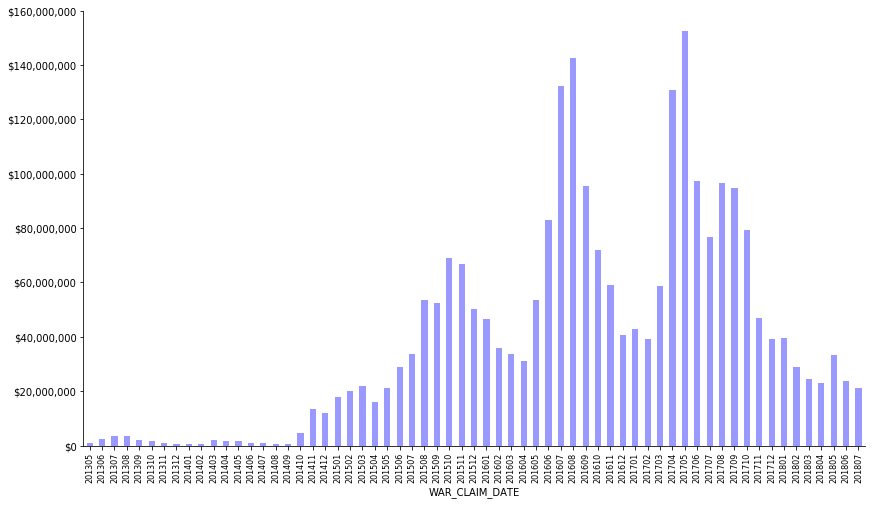

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

fig = plt.figure(figsize=(14,8))
ax = plt.subplot(1,1,1)
ax.yaxis.set_major_formatter(FuncFormatter('${:,.0f}'.format))
plt.xticks(rotation=270, fontsize=8)
by_month.sort_index().plot.bar(ax=ax, color='b', alpha=0.4)
sns.despine()